In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from loading import load_session_data
from behavior import get_behav_units
from target import get_spike_counts, build_tgt_matrix, build_silence_matrix
from scipy import stats
from scipy import signal
from functools import reduce
from statsmodels.formula.api import ols, glm
from postprocessing.spiketrain import instantaneous_rate

import pandas as pd

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = selected_57
sessions.sort()
selected = [
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
]
selected

['57_SIT_2024-01-04_14-16-22', '57_SIT_2024-01-04_14-52-59']

In [17]:
session = selected[0]
session

'57_SIT_2024-01-04_14-16-22'

In [23]:
# load session
#session_data = load_session_data(session, load_aeps=False)
animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')
units_file = os.path.join(source, animal, session, 'units.h5')
moseq_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
moseq_units_glm = os.path.join(source, animal, session, 'analysis', 'MoSeq_units_GLM.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(moseq_file, 'r') as f:
    syl_ratio_mx  = np.array(f['syl_ratio_mx'])
    idxs_srm_tl   = np.array(f['idxs_srm_tl'])
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
    
syl_usages = np.array([syl_ratio_mx[:, i].mean() for i in range(syl_ratio_mx.shape[1])])
syl_count  = len(syl_usages)
syl_count

10

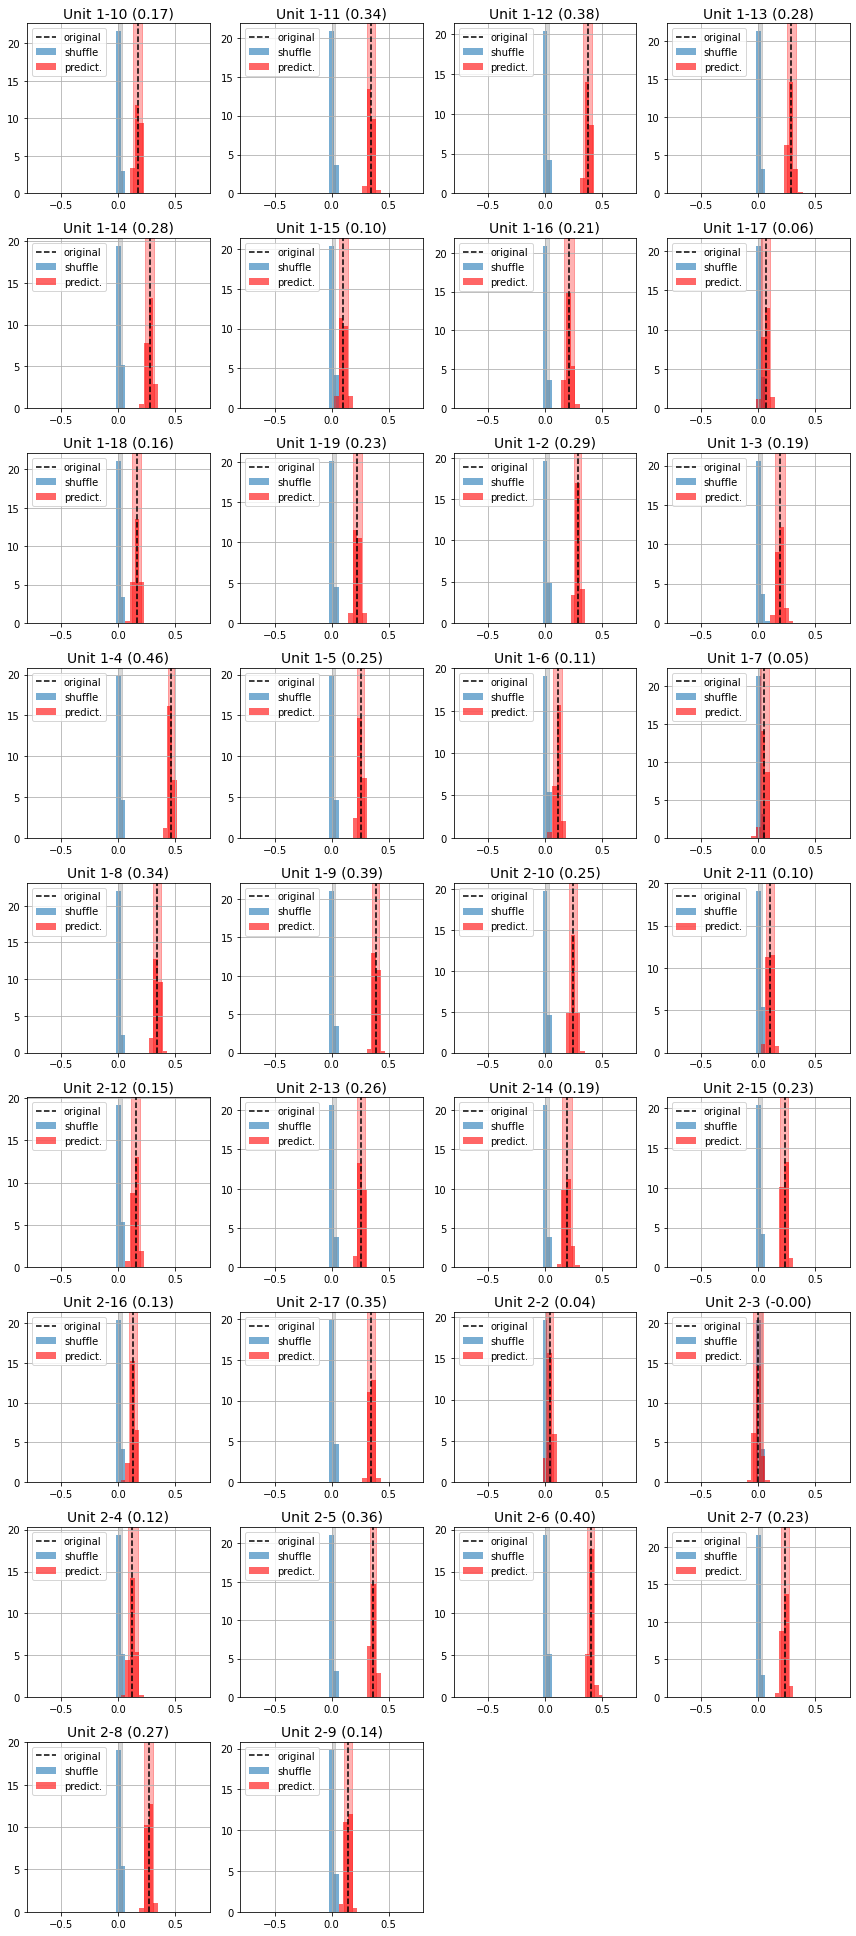

In [28]:
cols = 4
rows = int(len(unit_names)/cols) + 1
fig = plt.figure(figsize=(12, 3*rows))

for i, unit in enumerate(unit_names):
    with h5py.File(moseq_units_glm, 'r') as f:
        grp = f['units'][unit]
        corr_glm_fit_orig       = np.array(grp['corr_glm_fit_orig'])
        corr_glm_fit_shuffled   = np.array(grp['corr_glm_fit_shuffled'])
        corr_glm_fit_train_test = np.array(grp['corr_glm_fit_train_test'])
    
    # take only coeffs where p-val < 0.95 (all of them)
    coeffs_shuf = corr_glm_fit_shuffled[corr_glm_fit_shuffled[:, 1] < 0.95][:, 0]
    coeffs_chun = corr_glm_fit_train_test[corr_glm_fit_train_test[:, 1] < 0.95][:, 0]
    bins = np.linspace(-1, 1, 50)
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(coeffs_shuf, bins=bins, alpha=0.6, density=True, label='shuffle', color='tab:blue')
    ax.hist(coeffs_chun, bins=bins, alpha=0.6, density=True, label='predict.', color='red')
    ax.axvspan(np.percentile(coeffs_shuf, 5), np.percentile(coeffs_shuf, 95), alpha=0.3, color='gray')
    ax.axvspan(np.percentile(coeffs_chun, 5), np.percentile(coeffs_chun, 95), alpha=0.3, color='red')
    ax.axvline(coeffs_chun.mean(), color='black', ls='--', label='original')
    ax.set_xlim(-0.8, 0.8)
    ax.grid()
    ax.legend(loc='upper left')
    #ax.set_xlabel('Corr. coeff. Neuron - GLM fit', fontsize=14)
    ax.set_title('Unit %s (%.2f)' % (unit, coeffs_chun.mean()), fontsize=14)
    
fig.tight_layout()
#fig.savefig(os.path.join(session_data['report_path'], 'moseq_glm_corr_stats.pdf'))

## GLM syllable profiles

In [26]:
# select units with strong behav correlation
#behav_units = get_behav_units(session)
#len(behav_units)

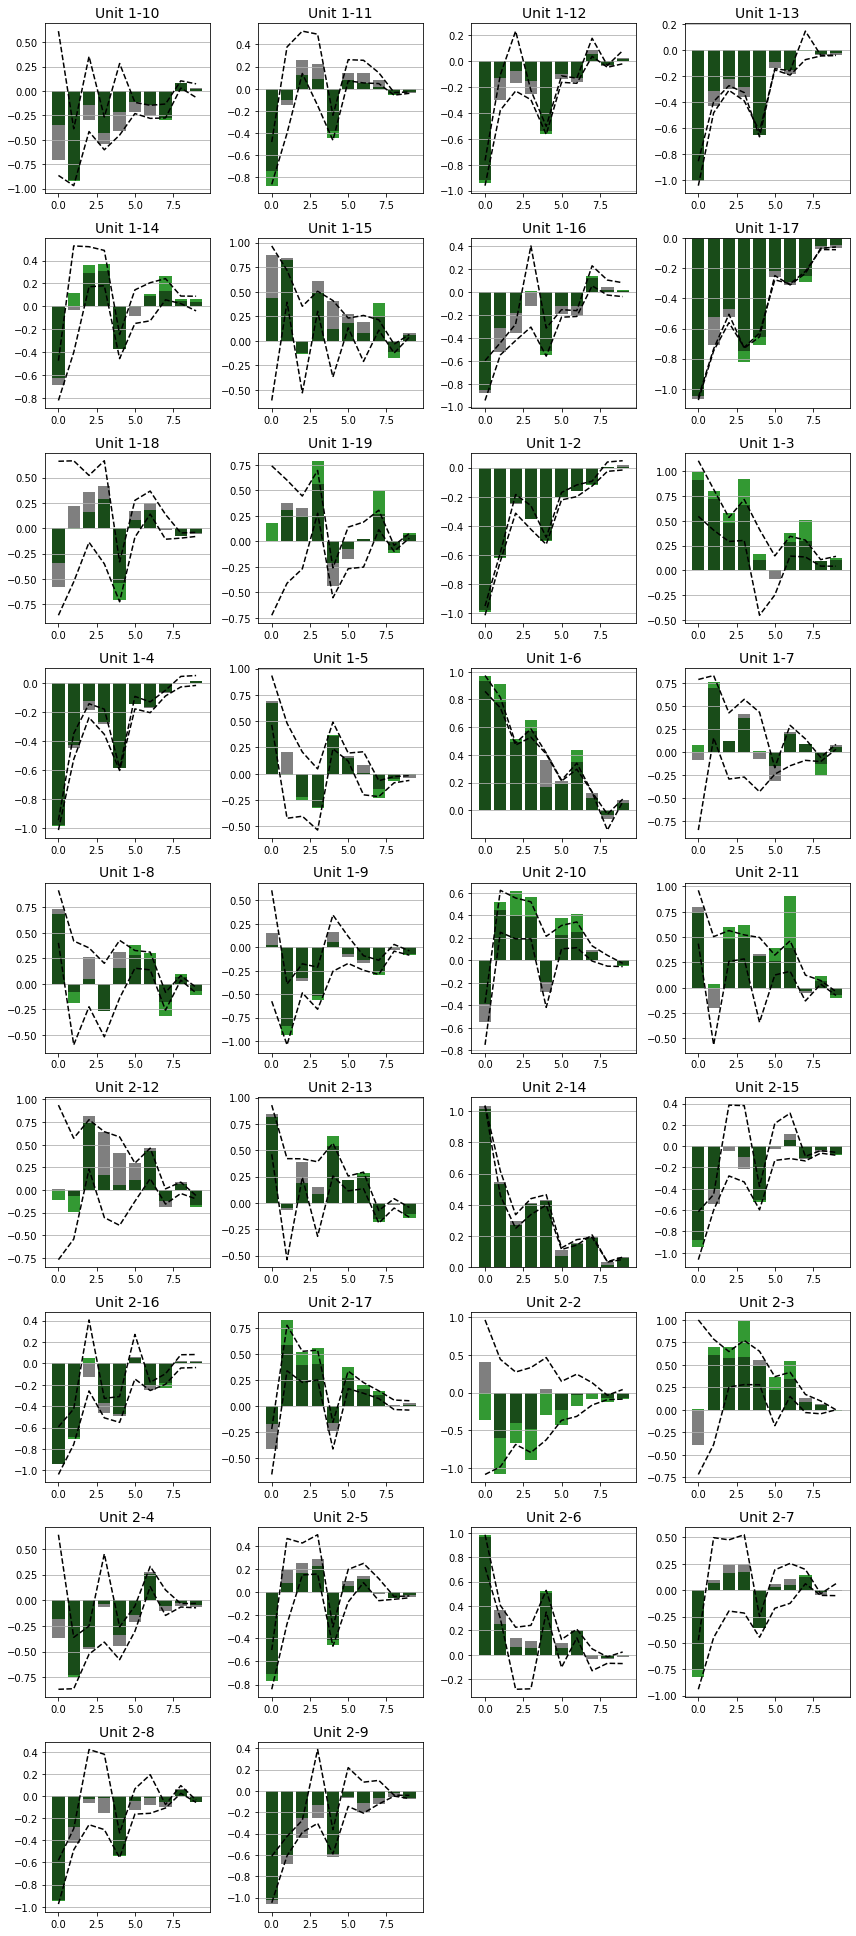

In [33]:
cols = 4
rows = int(len(unit_names)/cols) + 1
fig = plt.figure(figsize=(12, 3*rows))


def to_scaled(vec):
    return vec/(np.abs(vec.min() - vec.max()))

for i, unit in enumerate(unit_names):
    #i_rate = session_data['single_units'][unit]
    
    with h5py.File(moseq_units_glm, 'r') as f:
        grp = f['units'][unit]
        glm_cf_mx       = np.array(grp['glm_cf_mx'])
        glm_pv_mx       = np.array(grp['glm_pv_mx'])
        glm_fit_params  = np.array(grp['glm_fit_params'])
        glm_fit_pvalues = np.array(grp['glm_fit_pvalues'])
    
    # remove non-significant ones - make it worse actually
    #glm_fit_params[glm_fit_pvalues > 0.1] = 0
            
    means     = np.zeros(syl_count)
    perc_low  = np.zeros(syl_count)
    perc_high = np.zeros(syl_count)
    
    syll_ids = list(np.arange(syl_count).astype(np.int16))
    for idx_syll in syll_ids:
        coeffs = glm_cf_mx[glm_pv_mx[:, idx_syll + 1] < 0.05][:, idx_syll + 1] # 0th is intercept
        if len(coeffs) > 5:  # some coeffs might never be significant
            means[idx_syll]     = coeffs.mean()
            perc_low[idx_syll]  = np.percentile(coeffs, 5)
            perc_high[idx_syll] = np.percentile(coeffs, 95)
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.bar(syll_ids, to_scaled(glm_fit_params[1:]*syl_usages), alpha=0.8, color='green')
    ax.bar(syll_ids, to_scaled(means*syl_usages), alpha=0.5, color='black')
    ax.plot(syll_ids, to_scaled(perc_low*syl_usages), ls='--', color='black')
    ax.plot(syll_ids, to_scaled(perc_high*syl_usages), ls='--', color='black')
    #ax.axvline(corr_glm_fit_orig[0], color='black', ls='--', label='original')
    #ax.set_xlim(-0.8, 0.8)
    #ax.grid()
    #ax.legend(loc='upper left')
    #ax.set_xlabel('Corr. coeff. Neuron - GLM fit', fontsize=14)
    ax.set_title('Unit %s' % unit, fontsize=14)
    ax.grid(axis='y')
    
fig.tight_layout()
#fig.savefig(os.path.join(session_data['report_path'], 'glm_unit_profiles.pdf'))

In [30]:
syl_usages

array([0.24900194, 0.17695374, 0.11484095, 0.12623489, 0.13219614,
       0.055573  , 0.06409085, 0.03514794, 0.00555563, 0.00570704])